<a href="https://colab.research.google.com/github/ipediz/BachehayekhafaneTMU/blob/main/Propensity_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install econml
!pip install itertools
!pip install sklearn

from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML


import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd

In [ ]:
Data = pd.read_csv(r'All_STATE_CASUAL_READY_2.csv')

In [ ]:
from tabulate import tabulate

columns_to_drop = [
    'relative_time_m8andbeyond', 'relative_time_m7', 'relative_time_m6', 'relative_time_m5',
    'relative_time_m4', 'relative_time_m3', 'relative_time_m2', 'relative_time_m1', 'relative_time_0',
    'relative_time_p1', 'relative_time_p2', 'relative_time_p3', 'relative_time_p4',
    'relative_time_p5', 'relative_time_p6', 'relative_time_p7', 'relative_time_p8andbeyond',
    'cem_strata', 'cem_weights', 'new_timeperiod','county_code', 'nonbusiness_bankruptcy_percapita','business_bankruptcy_percapita', 'log_bankruptcy'
]


Data1= Data.drop(columns=columns_to_drop)
Data1 = Data1.dropna();

In [ ]:
Y = Data1['bankruptcy_per_capita'].values
T = Data1['Treatment'].values

In [ ]:
X = Data1[['monthly_earnings', 'medianhouseholdincome', 'labor_force', 'employed_individuals','population_estimation',]].values

In [ ]:

from sklearn.linear_model import LogisticRegression

In [ ]:
ps_model = LogisticRegression(C=1e6).fit(X,T)

In [ ]:
data_ps = Data1.assign(propensity_score=ps_model.predict_proba(X)[:, 1])


In [ ]:
data_ps[["Treatment", "bankruptcy_per_capita", "propensity_score"]].head()

,Treatment,bankruptcy_per_capita,propensity_score
0,0,1.351739,0.297230
1,0,0.901159,0.299455
2,0,1.065006,0.297751
3,0,1.105968,0.301933
4,1,1.022579,0.294295


In [ ]:
weight_t = 1/data_ps.query("Treatment==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("Treatment==0")["propensity_score"])
print("Original Sample Size", Data1.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 64428
Treated Population Sample Size 64455.95436897083
Untreated Population Sample Size 64435.365577385586


In [ ]:
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
!pip install causalinference
from causalinference import CausalModel

import graphviz as gr

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [ ]:
sns.boxplot(x="percent_over_60", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

Error in callback <function flush_figures at 0x78d6b1f551b0> (for post_execute):


KeyboardInterrupt: 



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



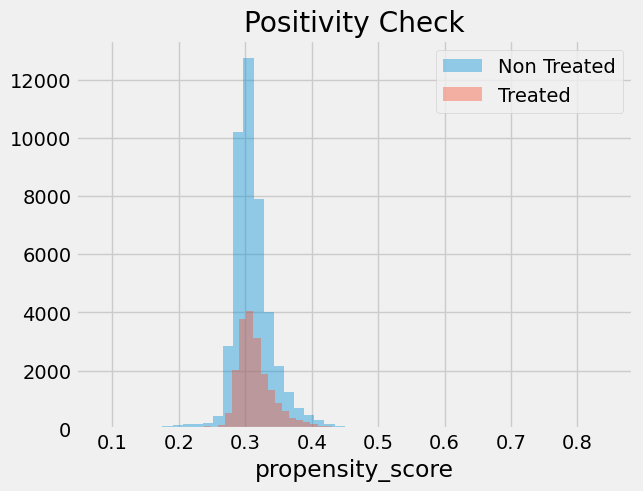

In [ ]:

sns.distplot(data_ps.query("Treatment==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("Treatment==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

In [ ]:
weight = ((data_ps["Treatment"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("Treatment==1")["bankruptcy_per_capita"]*weight_t) / len(Data1)
y0 = sum(data_ps.query("Treatment==0")["bankruptcy_per_capita"]*weight_nt) / len(Data1)

ate = np.mean(weight * data_ps["bankruptcy_per_capita"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.6494358809243951
Y0: 0.6547563586211339
ATE -0.0053204776967321395


In [ ]:

from joblib import Parallel, delayed # for parallel processing

In [ ]:
def run_ps(Data1, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(X, T).predict_proba(X)[:, 1]

    weight = (T-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * Y) # compute the ATE

np.random.seed(88)

bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(Data1.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



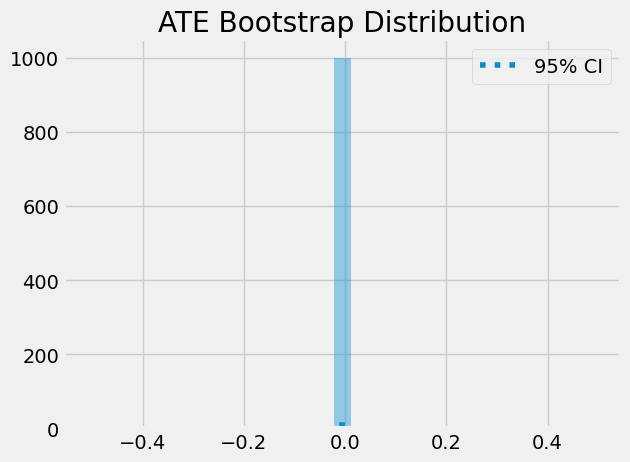

In [ ]:


sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



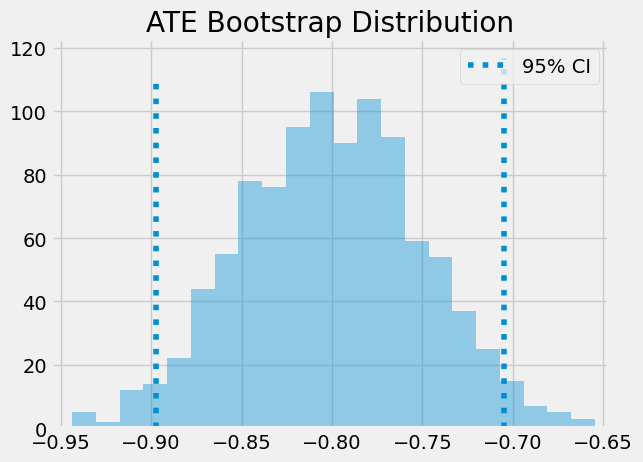

In [ ]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, plt.ylim()[1], linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, plt.ylim()[1], linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend()
buffer = 0.3 * (np.percentile(ates, 97.5) - np.percentile(ates, 2.5))  # Add a small buffer
plt.xlim(np.percentile(ates, 2.5) - buffer, np.percentile(ates, 97.5) + buffer)
plt.show()


In [ ]:
!pip install causalinference
from causalinference import CausalModel

In [ ]:
subsampled_data = data_ps.iloc[::28, :]

In [ ]:
cm = CausalModel(
    Y=subsampled_data["bankruptcy_per_capita"].values,
    D=subsampled_data["Treatment"].values,
    X=subsampled_data[["propensity_score"]].values
)

cm.est_via_matching(matches=1, bias_adj=False)

print(cm.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.048      0.031     -1.530      0.126     -0.109      0.013
           ATC     -0.036      0.035     -1.030      0.303     -0.103      0.032
           ATT     -0.068      0.036     -1.894      0.058     -0.139      0.002

